# Исследование объявлений о продаже квартир

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [245]:
#импортировали библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [246]:
#прочитали данные из файла
games = pd.read_csv('/datasets/games.csv')

In [247]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [248]:
#вывели информацию о данных
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Изначальные данные представлены за 1980-2016 года и содержат 16715 строк и 11 столбцов. Пустые значения могут быть связаны с неполнотой предоставленных данных и недостаточной информацией об играх, например точно может быть неизвестна дата выхода игры, выпущеннй около сорока лет назад.

### Шаг 2. Предобработка данных

- Замените названия столбцов (приведите к нижнему регистру);
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
- Обработайте пропуски при необходимости:
 - Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
 - Опишите причины, которые могли привести к пропускам;
 - Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [249]:
#приведите к нижнему регистру
games.set_axis(['name',
               'platform',
               'year_of_release',
               'genre',
               'na_sales',
               'eu_sales',
               'jp_sales',
               'other_sales',
               'critic_score',
               'user_score',
               'rating'], 
               axis = 'columns', 
               inplace = True)

In [252]:
#Обработайте пропуски при необходимости
games.dropna(subset = ['name'], inplace = True)#удалили пропуски в столбце name,тк их мало

В столбце year_of_release 269 пропусков, это где-то 1% всех данных. Он не повлияет на общий анализ, поэтому можем удалить эти пропуски.

In [255]:
games.dropna(subset = ['year_of_release'], inplace = True)

In [256]:
#Преобразуйте данные в нужные типы.
games['year_of_release'] = games['year_of_release'].astype('int')#заменили на int, так как год не мб дробным

In [257]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

погуглив выяснили, что:
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех».Первоначально "K-A" ("Kids to Adults").
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»

поэтому заполним пропуски в столбце rating на RP.

In [258]:
games['rating'] = games['rating'].fillna('RP')

#заменим значение 'K-A' на 'E', тк это это устаревшее значение
games['rating']=games['rating'].replace('K-A', 'E')

In [259]:
#приведем к нижнему регистру столбецы
games['name']=games['name'].str.lower()
games['platform']=games['platform'].str.lower()

In [260]:
#проверим наличае дубликатов в названии и платформе, 
#тк одну и ту же игру могли разрабатывать на нескольких платформах
games.duplicated(['name', 'platform']).sum()

3

In [261]:
#тк дубликатов мало, можем их удалить
games = games.drop_duplicates(['name', 'platform']).reset_index(drop = True)
games.duplicated(['name', 'platform']).sum()

0

In [262]:
#заменим проруски critic_score медианой и преобразуем
#games['critic_score'] = games['critic_score'].fillna(games['critic_score'].mean()).astype('int')

In [263]:
#tbd означает,что оценка будет определена,ее можно заменить на nan
games['user_score'].loc[games['user_score'] == 'tbd'] = np.nan
games['user_score'] = games['user_score'].astype('float')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Шаг 3. Проведите исследовательский анализ данных
1. Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
2. Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
3. Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
4. Не учитывайте в работе данные за предыдущие годы.
5. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
6. Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. Велика ли разница в продажах? А в средних продажах на разных платформах? Опишите результат.
7. Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
8. Соотнесите выводы с продажами игр на других платформах.
9. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [264]:
#Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
def years(data):
    data_pivot = data.pivot_table(index='year_of_release', values ='name', aggfunc='count')
    data_pivot.plot(y = 'name', style = 'o-', figsize = (20, 10),grid = True)
    print(data_pivot)

                 name
year_of_release      
1980                9
1981               46
1982               36
1983               17
1984               14
1985               14
1986               21
1987               16
1988               15
1989               17
1990               16
1991               41
1992               43
1993               60
1994              121
1995              219
1996              263
1997              289
1998              379
1999              338
2000              350
2001              482
2002              829
2003              775
2004              762
2005              938
2006             1006
2007             1197
2008             1427
2009             1426
2010             1255
2011             1136
2012              651
2013              544
2014              581
2015              606
2016              502


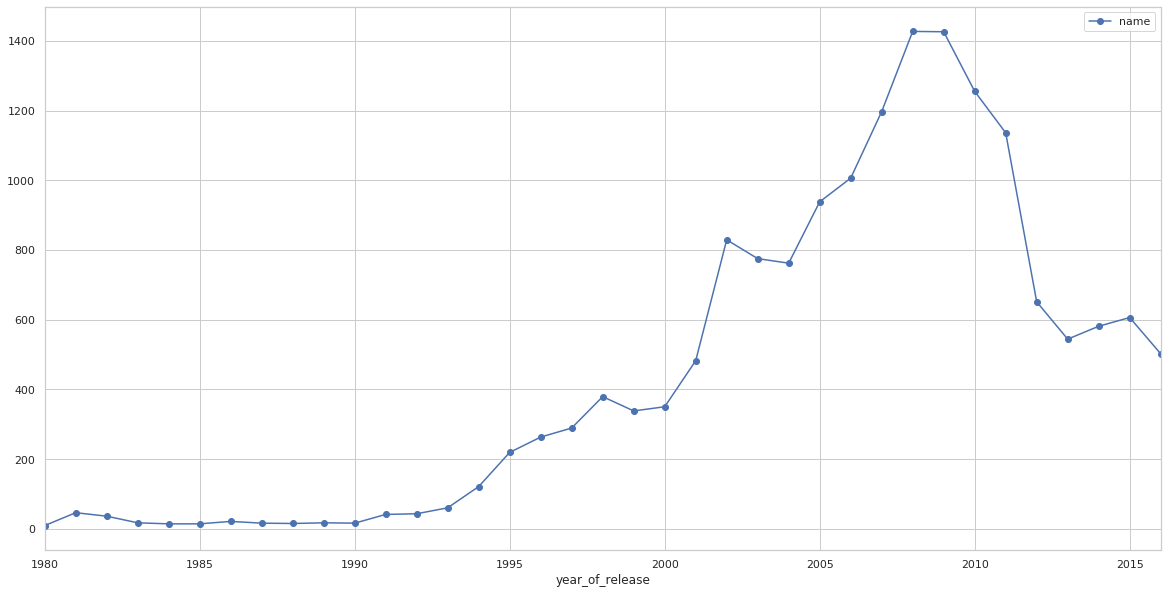

In [265]:
years(games)

С 1991 года количество игр возрасстает. Пик выпуска игр пришеля на 2008 и 2009 года. После этого количество игр упало до 502 в 2016 году. Данные за все периоды не так важны, тк то что было почти 40 лет назад не очень сильно повлияет на прогноз. Лучше использовать данные за последние 3-5 лет.

In [266]:
#добавим новый столбец с продажами по всем странам
games['all_sales'] = games['na_sales']+games['eu_sales']+games['jp_sales']+games['other_sales']

In [267]:
#платформы с наибольшими суммарными продажами
games_platform_pivot=games.pivot_table(index='platform', 
                        values ='all_sales',
                        aggfunc='sum').sort_values(by = 'all_sales',ascending = False)
games_platform_pivot

,all_sales
platform,
ps2,1233.56
x360,959.99
ps3,931.33
wii,891.18
ds,802.78
ps,727.58
ps4,314.14
gba,312.88
psp,289.53


Платформы с наибольшими суммарными продажами: ps2, x360, ps3, wii, ds, ps.

In [268]:
games_top=games.query('("ps2","x360","ps3","wii","ds","ps") in platform')

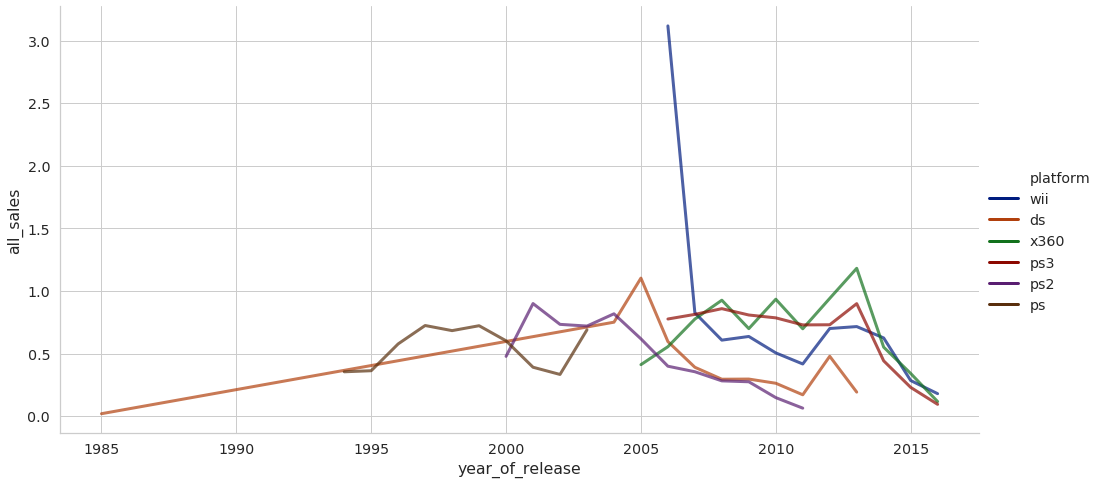

In [269]:
sns.set(font_scale=1.3, style='whitegrid', rc={'lines.linewidth':3})
sns.relplot(x = "year_of_release",y="all_sales", hue="platform",kind='line',
             data=games_top, height=7, aspect=2, ci= None,alpha=0.7, palette='dark')
plt.grid(True)
plt.show()

In [270]:
print('ds',games_top[games_top['platform'] == "ds"]['year_of_release'].min())
print('ps',games_top[games_top['platform'] == "ps"]['year_of_release'].min())
print('ps2',games_top[games_top['platform'] == "ps2"]['year_of_release'].min())
print('x360',games_top[games_top['platform'] == "x360"]['year_of_release'].min())
print('ps3',games_top[games_top['platform'] == "ps3"]['year_of_release'].min())
print('wii',games_top[games_top['platform'] == "wii"]['year_of_release'].min())

ds 1985
ps 1994
ps2 2000
x360 2005
ps3 2006
wii 2006


Новые платформы появлялись приблизительно каждые 5 лет до 2006 года.

In [271]:
#возьмем данные за последние 3 года для прогноза
games_new=games_top.query('year_of_release>2013')

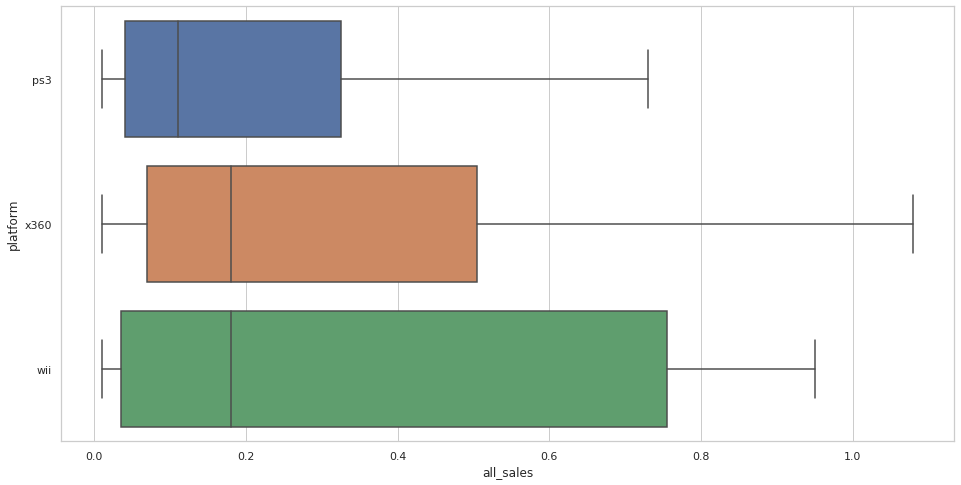

In [272]:
#Постройте график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам. 
sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
sns.boxplot(y='platform',x='all_sales',data=games_new, orient='h',showfliers=False)

Выбрав только актуальные данные за 2014-2016 года. Обнаружилось, что данных по платформам ds,ps,ps2 за эти года нет. Разница в продажах у всех платформ разная.

- Платформа wii продавалась от 0.04 до 0.76 миллионов долларов. С медианой 0.18.
- Платформа x360 продавалась от 0.08 до 0.5 миллионов долларов. С медианой 0.18.
- Платформа ps3 продавалась от 0.05 до 0.35 миллионов долларов. С медианой 0.1.

Рассмотрим все 3 платформы.

In [273]:
#начнем с wii
games_wii=games_new.query('"wii" in platform')
games_wii.sort_values(by = 'all_sales',
                        ascending = False).loc[:, ['name', 'critic_score','user_score','all_sales']]

,name,critic_score,user_score,all_sales
839,just dance 2015,NaN,8.4,2.01
2150,just dance 2016,NaN,NaN,0.95
2151,skylanders: trap team,NaN,NaN,0.95
3560,fifa 15,NaN,4.3,0.56
7866,how to train your dragon 2,NaN,NaN,0.18
7884,just dance 2017,NaN,NaN,0.18
8799,skylanders: superchargers,NaN,NaN,0.15
13357,disney planes fire & rescue,NaN,NaN,0.04
14449,barbie and her sisters puppy rescue,NaN,NaN,0.03
15883,penguins of madagascar,NaN,NaN,0.01


In [274]:
#далее платформа x360
games_x360=games_new.query('"x360" in platform')
games_x360.sort_values(by = 'all_sales',
                        ascending = False).loc[:, ['name', 'critic_score','user_score','all_sales']].head(30)

,name,critic_score,user_score,all_sales
262,call of duty: advanced warfare,NaN,4.9,4.28
490,fifa 15,NaN,4.2,2.92
818,madden nfl 15,NaN,5.5,2.05
887,destiny,NaN,4.7,1.92
1038,call of duty: black ops 3,NaN,NaN,1.70
1119,nba 2k15,NaN,3.0,1.63
1169,fifa 16,NaN,2.9,1.57
1408,titanfall,83.0,5.9,1.36
1532,the lego movie videogame,69.0,7.2,1.27
1569,watch dogs,NaN,5.0,1.25


In [275]:
#далее платформа ps3
games_ps3=games_new.query('"ps3" in platform')
games_ps3.sort_values(by = 'all_sales',
                        ascending = False).loc[:, ['name', 'critic_score','user_score','all_sales']].head(30)

,name,critic_score,user_score,all_sales
180,minecraft,NaN,NaN,5.27
254,call of duty: advanced warfare,NaN,4.8,4.36
263,fifa 15,NaN,4.5,4.28
548,fifa 16,NaN,3.2,2.70
1010,watch dogs,NaN,5.1,1.74
1051,call of duty: black ops 3,NaN,NaN,1.69
1129,destiny,NaN,4.5,1.61
1300,madden nfl 15,NaN,2.7,1.46
1448,nba 2k15,NaN,3.5,1.34
1502,far cry 4,NaN,7.3,1.29


Оценки критиков и пользователей различны. Оценки влияют на продажи, чем выше оценка, тем лучше продается игра. Однако есть исключения, например игра fifa 16 имеет низкую оценку пользователей, но продается на этой платформе ps3 хорошо. Или же игра dark souls ii имеет высокую оценку критиков и пользователей, даже больше, чем лидер продаж - игра minecraft	. Однако сильно уступает по продажам.

In [276]:
#посчитайте корреляцию между отзывами и продажами.
games['critic_score'].corr(games['all_sales'])

0.24544660258744538

In [277]:
games['user_score'].corr(games['all_sales'])

0.08795661382847333

Зависимость между ними оценками пользователей и продажами есть; зависимость между ними оценками критиков и продажами есть. Зависимость может быть вызвана тем, что многие люди смотрят на оценку игры перед покупкой.

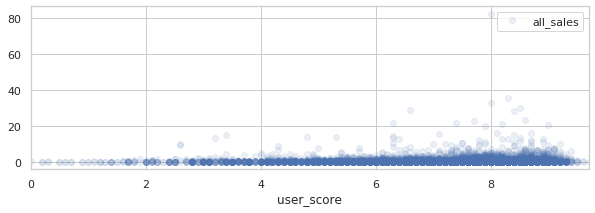

In [278]:
#Постройте диаграмму рассеяния
games.plot(x = 'user_score', 
           y = 'all_sales',
           style = 'o',
           grid=True, 
           figsize=(10, 3), 
           alpha=0.1)

Больше всего продаж игр с высокими оценками пользователей около 8.

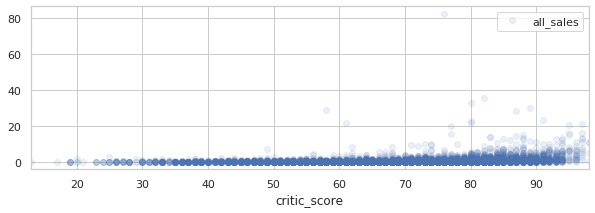

In [279]:
games.plot(x = 'critic_score', 
           y = 'all_sales',
           style = 'o',
           grid=True, 
           figsize=(10, 3), 
           alpha=0.1)

С оценки критиков 68 продажи начинают расти.

In [280]:
games_other=games.query('("x360","ps3","wii") not in platform')
games_other.sort_values(by = 'all_sales',
                        ascending = False).loc[:, ['name', 'critic_score','user_score','all_sales','platform']].head(30)

,name,critic_score,user_score,all_sales,platform
1,super mario bros.,NaN,NaN,40.24,nes
4,pokemon red/pokemon blue,NaN,NaN,31.38,gb
5,tetris,NaN,NaN,30.26,gb
6,new super mario bros.,89.0,8.5,29.80,ds
9,duck hunt,NaN,NaN,28.31,nes
10,nintendogs,NaN,NaN,24.67,ds
11,mario kart ds,91.0,8.6,23.21,ds
12,pokemon gold/pokemon silver,NaN,NaN,23.09,gb
17,grand theft auto: san andreas,95.0,9.0,20.81,ps2
18,super mario world,NaN,NaN,20.62,snes


Можно сделать вывод, что продажи на других платформах в основном зависят от оценок. Однако есть исключения.

In [281]:
games.pivot_table(index='genre', values ='all_sales', 
                  aggfunc='sum').sort_values(by = 'all_sales',ascending = False)

,all_sales
genre,
Action,1716.52
Sports,1309.66
Shooter,1041.36
Role-Playing,931.08
Platform,825.55
Misc,790.29
Racing,722.16
Fighting,442.66
Simulation,387.96


Самая большая прибыль у жанра Action, а самые низкие продажи у жанра Strategy. Однако мы не можем утвреждать, то Action самый прибыльный жанр, так как затраты на производство такой игры обходятся дороже, чем на производство низкоприбыльных игр по типу Puzzle.

### Шаг 4. Составьте портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

AxesSubplot(0.125,0.125;0.775x0.755)



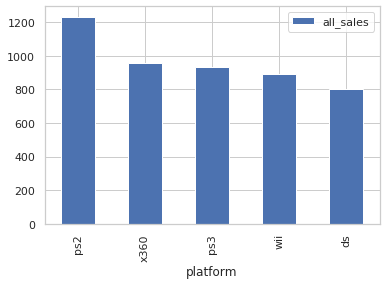

In [282]:
def top(data, location, genre):
    print(games.pivot_table(index = genre, 
                            values = location, 
                            aggfunc='sum').sort_values(by = location,ascending = False).head().plot(kind='bar'))
    print()
    
#Самые популярные платформы (топ-5)
top(games, 'all_sales', 'platform')

Самые популярные платформы: ps2, x360, ps3, wii, ds.          

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)



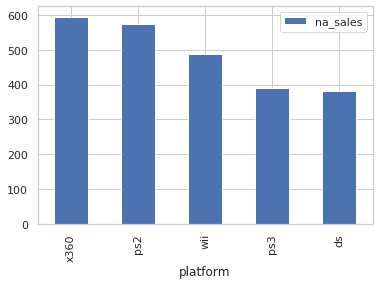

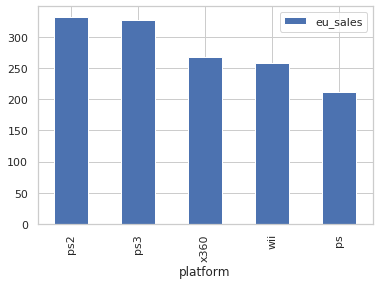

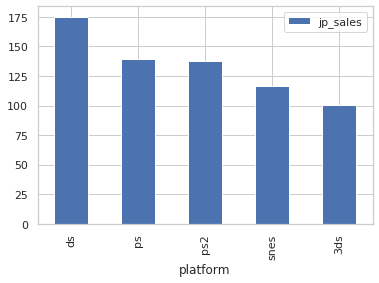

In [283]:
#определим самые популярные платформы в каждом регионе
top(games, 'na_sales', 'platform')
top(games, 'eu_sales', 'platform')
top(games, 'jp_sales', 'platform')

Платформы x360, ps2, ps3, wii популярны в Северной Америке и Европе. Платформы ds и ps лидируют в Японии, а также популярны в Северной Америке и Европе соответственно. В Японии поплярны платформы ps2, snes, 3ds.

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)



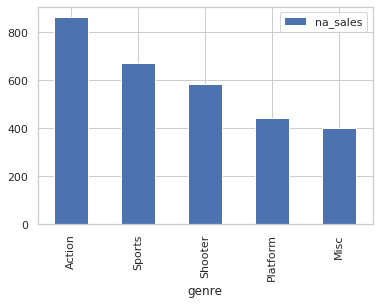

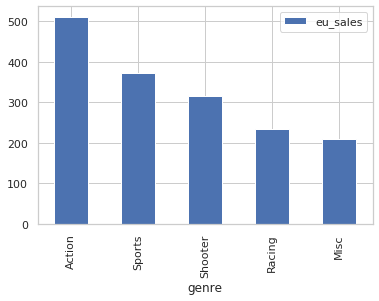

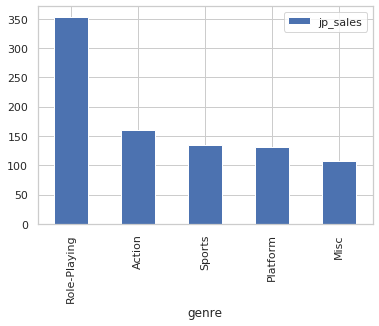

In [284]:
#Самые популярные жанры (топ-5)
for row in ['na_sales', 'eu_sales', 'jp_sales']:
    top(games, row, 'genre')

Жанры Action, Sports, Misc популярны в каждом регионе. В Европе и Северной Америке популярен жанр Shooter, в Северной Америке и Японии популярен жанр Platform. В Японии лидирует жанр Role-Playing. А также в Европе в топ попали Racing.

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)

AxesSubplot(0.125,0.125;0.775x0.755)



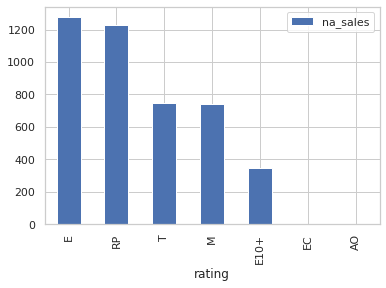

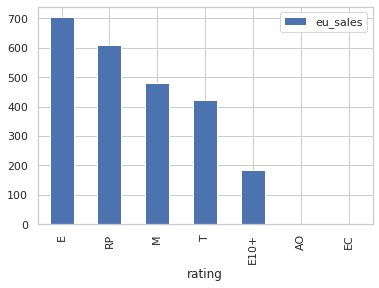

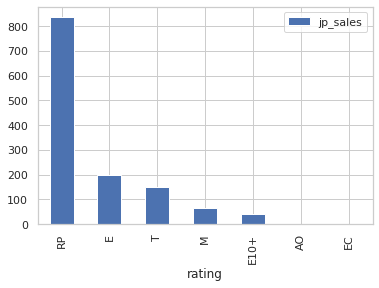

In [285]:
#Влияет ли рейтинг ESRB на продажи в отдельном регионе?
def esrb(data, location, genre):
    print(games.pivot_table(index = genre, 
                            values = location, 
                            aggfunc='sum').sort_values(by = location,ascending = False).plot(kind='bar'))
    print()
    
for row in ['na_sales', 'eu_sales', 'jp_sales']:
    esrb(games, row, 'rating')

Во всех регионах лидирующие позиции занимают игры с рейтингом «E» («Everyone») и «RP» («Rating Pending»). В Серной Америке и Европе самый маленький процент продаж у игр с рейтингом «AO» («Adults Only 18+») и «EC» («Early childhood»), а в Японии игры с таким рейтингом не продаются. В Северной Америке и Европе игры с рейтингом «T» («Teen») и «M» («Mature») имеют примерно одинаковые продажи и занимают 3 и 4 место в списке продаж. В Японии же рейтинг «M» продаются хуже. Во всех регионах рейтинг «E10+» («Everyone 10 and older») занимает 5 место.

### Шаг 5. Проверьте гипотезы
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.
Задайте самостоятельно пороговое значение alpha.

Поясните:
- Как вы сформулировали нулевую и альтернативную гипотезы;
- Какой критерий применили для проверки гипотез и почему.

In [286]:
alpha = 0.05

def gipoteza(data_1, data_2):
    results = st.ttest_ind(
        data_1, 
        data_2,)

    print('p-value:', results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Так как в столбце user_score есть пропуски, поэтому при подсчете p-value получаем nan и пропусков много, а заполнить их более менее обосновано возможности нет. В наших данных нет значений оценок пользователей меньше 0, поэтому будем проверять положительные значения, тем самым исключив пропуски.

In [288]:
games[games['user_score'] < 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales


In [289]:
xone = games[(games['platform'] == 'xone') & (games['user_score'] > 0)]['user_score']
pc = games[(games['platform'] == 'pc') & (games['user_score'] > 0)]['user_score']

- H0: средний пользовательский рейтинг платформ xone и pc одинаковый
- H1: средний пользовательский рейтинг платформ xone и pc различается

In [290]:
gipoteza(xone, pc)

p-value: 1.4016223685120801e-05
Отвергаем нулевую гипотезу


Значит рейтинг платформ xone и pc различен.

In [291]:
action = games[(games['genre'] == 'Action') & (games['user_score'] > 0)]['user_score']
sport = games[(games['genre'] == 'Sports') & (games['user_score'] > 0)]['user_score']

- H0: средний пользовательский рейтинг жанров Action и Sports одинаковый
- H1: средний пользовательский рейтинг жанров Action и Sports различается

In [292]:
gipoteza(action, sport)

p-value: 0.06833686503882228
Не получилось отвергнуть нулевую гипотезу


Значит средний пользовательский рейтинг жанров Action и Sports одинаковый.

### Шаг 6. Напишите общий вывод

1) Были проанализированы данные интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Были выявлены определяющие успешность игры закономерности. 

Изначальные данные представлены за 1980-2016 года и содержат 16715 строк и 11 столбцов. Удалили пропуски в столбце названия,так как их мало. Пропуски в столбце с годом выпуска игры были заменены на будующий год, так как скорее всего они находятся в ствдии разработки. В столбце рейтинга пустые значения были заменены на «RP» — «Рейтинг ожидается», а значения «Е» и «К-А» были объединены в одно, так как это разные названия одного и того же. Дубликаты в названиях и платформах были удалены. Пропуски в оценки пользователей и критиков были заменены среднем.

2) С 1991 года количество игр возрасстает. Пик выпуска игр пришеля на 2008 и 2009 года. После этого количество игр упало до 502 в 2016 году. Данные за все периоды не так важны, тк то что было почти 40 лет назад не очень сильно повлияет на прогноз. Лучше использовать данные за последние 3-5 лет. Новые платформы появлялись приблизительно каждые 5 лет до 2006 года.Выбрали данные для анализа за 3 года.

Платформы с наибольшими суммарными продажами: ps2, x360, ps3, wii, ds, ps.
Выбрав только актуальные данные за 2014-2016 года. Обнаружилось, что данных по платформам ds,ps,ps2 за эти года нет. Разница в продажах у всех платформ разная.

- Платформа wii продавалась от 0.04 до 0.76 миллионов долларов. С медианой 0.18.
- Платформа x360 продавалась от 0.08 до 0.5 миллионов долларов. С медианой 0.18.
- Платформа ps3 продавалась от 0.05 до 0.35 миллионов долларов. С медианой 0.1.

3) Рассмотрели оценки влияние оцеок критиков и пользователей на продали на примере платформы ps2.

Оценки критиков и пользователей различны. Оценки влияют на продажи, чем выше оценка, тем лучше продается игра. Однако есть исключения, например игра fifa 16 имеет низкую оценку пользователей, но продается на этой платформе ps3 хорошо. Или же игра dark souls ii имеет высокую оценку критиков и пользователей, даже больше, чем лидер продаж - игра minecraft . Однако сильно уступает по продажам.

Зависимость между ними оценками пользователей и продажами есть; зависимость между ними оценками критиков и продажами есть. Зависимость может быть вызвана тем, что многие люди смотрят на оценку игры перед покупкой.

Можно сделать вывод, что продажи на других платформах в основном зависят от оценок. Однако есть исключения.

Самая большая прибыль у жанра Action, а самые низкие продажи у жанра Strategy. Однако мы не можем утвреждать, то Action самый прибыльный жанр, так как затраты на производство такой игры обходятся дороже, чем на производство низкоприбыльных игр по типу Puzzle.

4) Был проанализирован портрет пользователя каждого региона.

Платформы x360, ps2, ps3, wii популярны в Северной Америке и Европе. Платформы ds и ps лидируют в Японии, а также популярны в Северной Америке и Европе соответственно. В Японии поплярны платформы ps2, snes, 3ds.

Жанры Action, Sports, Misc популярны в каждом регионе. В Европе и Северной Америке популярен жанр Shooter, в Северной Америке и Японии популярен жанр Platform. В Японии лидирует жанр Role-Playing. А также в Европе в топ попали Racing.

Во всех регионах лидирующие позиции занимают игры с рейтингом «E» («Everyone») и «RP» («Rating Pending»). В Серной Америке и Европе самый маленький процент продаж у игр с рейтингом «AO» («Adults Only 18+») и «EC» («Early childhood»), а в Японии игры с таким рейтингом не продаются. В Северной Америке и Европе игры с рейтингом «T» («Teen») и «M» («Mature») имеют примерно одинаковые продажи и занимают 3 и 4 место в списке продаж. В Японии же рейтинг «M» продаются хуже. Во всех регионах рейтинг «E10+» («Everyone 10 and older») занимает 5 место.

5) Были проверены гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

    - H0: средний пользовательский рейтинг платформ xone и pc одинаковый
    - H1: средний пользовательский рейтинг платформ xone и pc различается
    
Значит рейтинг платформ xone и pc различен.

- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.

    - H0: средний пользовательский рейтинг жанров Action и Sports одинаковый
    - H1: средний пользовательский рейтинг жанров Action и Sports различается
    
Значит средний пользовательский рейтинг жанров Action и Sports одинаковый.

Нулевая гипотеза-рейтинг жанров разный. Не получилось отвергнуть нулевую гипотезу, значит рейтинг жанров Action и Sports разный.